<div align="center">

# EEG Electrode Montage Optimization via Mixed-Integer Programming

**December 2, 2025**

**By: Steven Haworth**

---

**[📂 View Project on GitHub](https://github.com/stevehaworth02/optimal-electrode-mip)**

</div>

---

## Data Requirements
This notebook requires EEG data from sleep study participants. Due to Protected Health Information (PHI) regulations, the original dataset cannot be publicly shared.

</div>

---

## Click Any Section to Navigate (You may have to scroll down after selecting a section)

| Section | Description |
|---------|-------------|
| **[1. Introduction](#introduction)** | Problem statement, dataset background, and cost model |
| **[2. Approach & Methodology](#approach)** | Three-model optimization strategy and mathematical formulations |
| **[3. Optimization Models](#models)** | Model A, B, and C implementations using GAMSPY |
| **[4. Results & Analysis](#results)** | Pareto analysis, cross-validation, and visualizations |
| **[5. Conclusion](#conclusion)** | Key findings and clinical impact |
| **[6. Future Work](#future)** | Extensions and research directions |
| **[📚 Glossary](#glossary)** | Technical terms and parameter definitions |

---

<a id="introduction"></a>

<div style="font-size: 0.8em;">

## Problem Statement

EEG has existed as the gold standard for recording neuronal signals since its creation 1924.  Modern electroencephalogram (EEG) systems can employ up to 256 electrodes to capture neural activity, but using all of these electrodes comes at significant cost in setup time, computational resources (memory, storage, CPU/GPU workloads), and patient discomfort. Despite these costs, from seizure forecasting to the classification of dreams, there is no agreed upon standard for the optimal number of electrodes needed for neurological and psychiatric research. This project aims to settle the debate, and provide empirical evidence for optimal electrode selection in dream state classification. This project demonstrates that 56 carefully selected electrodes can achieve high performance while reducing the electrode count by up to 70% percent. 

## Background: The Dream Research Dataset (Center for Sleep & Consciousness, UW Madison)

The dataset comprises of 699 healthy participants who underwent overnight polysomnographic recording using a 185-electrode EEG system following the standardized 10-05 placement system. After sleeping for 7 hours, they were awakened and asked whether they had been dreaming. Researchers extracted 60 seconds of EEG data immediately preceding each awakening, subjects were asked if they were dreaming, and to explain the contents of their dream. This naturally yields 699 awakening events with 185 channels of EEG data paired with binary dream versus no-dream labels. In particular 348 dream epochs, and 351 no-dream epochs.

### Feature Engineering and Usefulness Scores

Alpha power, a slow-wave signal at (8-13 Hz), has been shown to correlate with dream reports and conscious awareness in sleep research. We computed relative alpha power for each electrode using Fast Fourier Transform on the 60-second EEG segments. In order to numerically quantify each electrode's contribution to classification, we trained an L2-regularized logistic regression classifier using alpha power features from all 185 electrodes. For each electrode and subject, we computed a contribution score based on the product of the learned weight and standardized feature value, then normalized these to a usefulness metric in the range [0,1]. The resulting usefulness matrix quantifies how valuable each electrode is for classifying each subject's dream state.

### Cost Model

I've decided to build three models: A simple MIP with the goal of minimizing electrodes to assist researchers in better selecting which electrodes are used in analysis, a cost-aware MIP to penalize electrodes who may be prone to noise or result in patient discomfort, and lastly a Symmetric Cost-Aware MIP that is all of the above but emphasizes the symmetry needed to rest an electrode montage on the human scalp. In order to make our optimization and predictions more generalizable, I incorporated placement cost to reflect real-world constraints. Standard electrodes receive a cost of 1.0, while difficult locations such as frontopolar sites, inferior temporal sites, and mastoid sites receive a cost of 1.5 due to placement challenges, and their proximity to the jaw and eyes which pose a high risk of chewing and blinking artifacts. If nomenclature is unclear, I apologise, and please refer to the glossary

</div>

In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
ELEC_CSV = Path("data/electrodes.csv")
USE_CSV  = Path("data/usefulness_real.csv")
FEAT_CSV = Path("data/features.csv")
elec = pd.read_csv(ELEC_CSV)   # name,cost,location label ,(x,y) coordinates of the eletrodes on the head
use  = pd.read_csv(USE_CSV)    # subject,electrode label,usefulness
E_list = sorted(elec["name"].astype(str).unique())
S_list = sorted(use["subject"].astype(str).unique())
a_df = use.pivot_table(index="electrode", columns="subject", values="usefulness", aggfunc="mean")\
         .reindex(index=E_list, columns=S_list).fillna(0.0)
c_ser = elec.set_index("name")["cost"].reindex(E_list).fillna(1.0)
print("E =", len(E_list), "S =", len(S_list), "A-shape:", a_df.shape)
feat = pd.read_csv(FEAT_CSV)  
X_all = feat.pivot_table(index="subject", columns="electrode", values="feature", aggfunc="mean")\
           .reindex(columns=E_list).fillna(0.0)
y_all = feat.drop_duplicates("subject").set_index("subject")["label"].reindex(X_all.index).astype(int)
def auc5cv_for_subset(cols):
    if len(cols) == 0:
        return np.nan
    Xsub = X_all[cols].copy()
    Xsub = (Xsub - Xsub.mean(0)) / (Xsub.std(0) + 1e-12)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    for tr, va in skf.split(Xsub, y_all):
        clf = LogisticRegression(max_iter=300, solver="liblinear", class_weight="balanced")
        clf.fit(Xsub.iloc[tr], y_all.iloc[tr])
        p = clf.predict_proba(Xsub.iloc[va])[:,1]
        aucs.append(roc_auc_score(y_all.iloc[va], p))
    return float(np.mean(aucs))


E = 185 S = 699 A-shape: (185, 699)


---

<a id="approach"></a>

## 2. Approach & Methodology

<div style="font-size: 0.8em;">

This project will employ a progressive optimization strategy that builds three mixed-integer programming models of increasing sophistication to demonstrate the value of each component in electrode selection. Rather than jumping directly to a complex formulation, we construct a pedagogical sequence where each model gets built on with a necessary refinement.

My approach is centered on optimizing a usefulness metric derived from supervised learning. As alluded to in the introdution, we first train an L2-regularized logistic regression classifier on alpha power features from all 185 electrodes to predict dream versus no-dream states. For each electrode-subject pair, we compute a contribution score as the product of the learned coefficient and standardized feature value, then normalize these scores to a usefulness metric in the range [0,1]. This usefulness matrix quantifies how valuable each electrode is for classifying each subject's dream state, and provides the foundation for our optimization constraints.

The three models follow a clear progression. Model A establishes a naive baseline by simply minimizing electrode count subject to a usefulness threshold of α=0.60. This demonstrates the fundamental limitation of count minimization without quality considerations. Model B adds cost awareness, penalizing artifact-prone electrode locations (frontopolar, inferior temporal, and mastoid sites) with a 1.5× cost multiplier while standard electrodes receive cost 1.0. This reveals whether signal quality improvements alone can overcome spatial coverage limitations (In other words, overcome does quality overcome a lack of brain acitivity). Model C introduces our full formulation, adding soft symmetry penalties through continuous slack variables that measure left-right asymmetry in electrode pairs. The symmetry penalty weight λ=0.5 encourages bilateral balance without imposing hard symmetry constraints that might exclude valid asymmetric solutions.

For Model C, I conduct a Pareto analysis by sweeping the usefulness threshold α across nine values from 0.30 to 0.95. Each α value represents a point on the tradeoff curve between electrode count and coverage requirements. Low α values (0.30-0.50) produce minimal montages suitable for screening applications, moderate values (0.60-0.70) balance performance and practicality, and high values (0.80-0.95) represent what most would consider research-grade configurations with comprehensive spatial coverage of the scalp. This sweep reveals the full Pareto frontier of optimal solutions and allows us to identify the sweet spot where adding more electrodes no longer improves performance.

We validate all selected montages using 5-fold stratified cross-validation on held-out subjects. For each optimized electrode subset, we train L2-regularized logistic regression classifiers with class balancing on four folds and evaluate on the fifth, rotating through all combinations. Performance is measured via ROC AUC averaged across folds, providing a clean estimate of how well each montage generalizes to unseen subjects. This validation procedure is used because the usefulness metric used in optimization is computed on the training set, and in order to truly make something clinically useful we must verify that high usefulness scores translate to strong held-out performance rather than overfitting to training data.

All optimization models are implemented in GAMSPY and solved using the CPLEX mixed-integer programming solver. The binary decision variables representing electrode selection, combined with continuous slack variables for symmetry penalties in Model C, create mixed-integer programs that CPLEX solves to proven optimality. This guarantees that our solutions are globally optimal for the specified objective functions and constraints, rather than local optima.

</div>


---

<a id="models"></a>

## 3. Optimization Models

<div style="font-size: 0.8em;">

The following three models demonstrate a progressive approach to electrode selection, with each model building on the limitations of the previous one. 

</div>

## Model A: Simple MIP (Minimize Electrode Count)

<div style="font-size: 0.8em;">

**Objective:** Find the minimum number of electrodes that meets a target usefulness threshold.

This is our **baseline model** that ignores placement costs and symmetry considerations. We simply minimize the total electrode count subject to meeting a usefulness constraint of α=0.60 for all subjects.

**Formulation:**

$$\begin{aligned}
\text{minimize} \quad & \sum_{e \in E} z_e \\
\text{s.t} \quad & \sum_{e \in E} a_{es} z_e \geq \alpha \quad \forall s \in S \\
& z_e \in \{0, 1\} \quad \forall e \in E
\end{aligned}$$

Where:
- $z_e$ = binary decision variable (1 if electrode $e$ is selected, 0 otherwise)
- $a_{es}$ = usefulness of electrode $e$ for subject $s$
- $\alpha$ = minimum total usefulness threshold (0.60)

</div>

In [11]:
from gamspy import Container, Set, Parameter, Variable, Equation, Model, Sum, Sense # Nice to avoid re-typing gp
def model_a_simple_mip(a_df, alpha=0.60):
    E_list = list(a_df.index)
    S_list = list(a_df.columns)
    m = Container()
    E = Set(m, name="E", records=E_list, description="Electrodes")
    S = Set(m, name="S", records=S_list, description="Subjects")
    a_records = a_df.stack().reset_index()
    a_records.columns = ['electrode', 'subject', 'usefulness']
    a = Parameter(m, name="a", domain=[E, S], records=a_records, 
                  description="Usefulness matrix")
    z = Variable(m, name="z", domain=[E], type="binary", 
                 description="Electrode selection")
    objective = Sum(E, z[E])
    usefulness_constraint = Equation(m, name="usefulness_constraint", domain=[S],
                                     description="Minimum usefulness per subject")
    usefulness_constraint[S] = Sum(E, a[E, S] * z[E]) >= alpha
    model = Model(m, name="ModelB", equations=[usefulness_constraint], 
                  sense=Sense.MIN, objective=objective)
    model.solve()
    z_sol = z.records
    selected = z_sol[z_sol['level'] > 0.5]['E'].tolist()
    obj_val = model.objective_value
    return selected, obj_val, model
selected_b, obj_b, model_b = model_a_simple_mip(a_df, alpha=0.60)
print(f"   Electrodes selected: {len(selected_b)}")
print(f"   Objective value: {obj_b:.2f}")
print(f"\n   Selected electrodes (first 10): {selected_b[:10]}")


   Electrodes selected: 4
   Objective value: 4.00

   Selected electrodes (first 10): ['FCC3', 'FT8', 'PO5h', 'T7']


---
<div style="font-size: 0.8em;">

## Hold-out 5-Fold CV Testing
**Performance:** ROC AUC = 0.5465 is barely better than random guessing

**Why is Model A's performance so poor?**

Model A's  approach of minimizing electrode count without considering placement quality can lead to several issues, lets consider some possibilities:

1. **Artifact-Prone Locations**: The optimizer selects the 4 electrodes with highest average usefulness scores, but these may be located near the eyes, jaw, or other artifact hotspots. Without a cost penalty, the model happily chooses difficult placements like frontopolar sites (Fp1, Fp2) or mastoid positions that are highly susceptible to eye blinks and other musclular artifacts.

2. **Insufficient Spatial Coverage**: Just 4 electrodes is a pitiful amount, and won't adequately capture the distributed neural activity associated with dreaming. While they technically meet the α=0.60 usefulness constraint on the training surrogate, this constraint doesn't guarantee good generalization to held-out subjects.


**The model has selected electrodes:** `['FCC3', 'FT8', 'PO5h', 'T7']` - I notice these include temporal sites (FT8, T7) which are notorious for jaw clenching artifacts.

If we want to take this simple model as a demonstration why real-world EEG montage design requires more than just minimizing electrode count. We need to incorporate **placement costs** to avoid artifact-prone regions and ensure better signal quality.

</div>

In [4]:
auc_b = auc5cv_for_subset(selected_b)
print(f"   ROC AUC: {auc_b:.4f}")

   ROC AUC: 0.5465


---
# Model B: Cost-Aware MIP

<div style="font-size: 0.8em;">

**Objective:** Minimize total placement cost, while similtaneously meeting the usefulness threshold.

This model hopes to improve on Model A by incorporating a placement cost for electrodes. Instead of treating all electrodes equally, we assign higher costs (1.5×) to difficult placements such as:
- **Frontopolar sites** (Fp1, Fp2, AFp3h, etc.) — prone to eye blink artifacts
- **Inferior temporal sites** (FT9, FT10, T9, T10) — susceptible to jaw clenching
- **Mastoid positions** (M1, M2, TP9, TP10) — muscle artifacts from neck movement

Standard electrodes receive cost = 1.0, while these artifact-prone locations receive cost = 1.5.


$$\begin{aligned}
\text{minimize} \quad & \sum_{e \in E} C_e z_e \\
\text{s.t} \quad & \sum_{e \in E} a_{es} z_e \geq \alpha \quad \forall s \in S \\
& z_e \in \{0, 1\} \quad \forall e \in E
\end{aligned}$$

Where:
- $C_e$ = placement cost of electrode $e$ (1.0 for standard, 1.5 for difficult)
- Other variables same as Model A

**My Hypothesis:** By penalizing artifact-prone electrodes, Model B should select a montage with better signal quality and improved classification performance compared to Model A.

</div>

In [5]:
def model_b_cost_aware(a_df, c_ser, alpha=0.60):
    E_list = list(a_df.index)
    S_list = list(a_df.columns)
    m = Container()
    E = Set(m, name="E", records=E_list, description="Electrodes")
    S = Set(m, name="S", records=S_list, description="Subjects")
    a_records = a_df.stack().reset_index()
    a_records.columns = ['electrode', 'subject', 'usefulness']
    a = Parameter(m, name="a", domain=[E, S], records=a_records,
                  description="Usefulness matrix")
    c_records = c_ser.reset_index()
    c_records.columns = ['electrode', 'cost']
    c = Parameter(m, name="c", domain=[E], records=c_records,
                  description="Electrode placement costs")
    z = Variable(m, name="z", domain=[E], type="binary",
                 description="Electrode selection")
    objective = Sum(E, c[E] * z[E])
    usefulness_constraint = Equation(m, name="usefulness_constraint", domain=[S],
                                     description="Minimum usefulness per subject")
    usefulness_constraint[S] = Sum(E, a[E, S] * z[E]) >= alpha
    model = Model(m, name="ModelB_CostAware", equations=[usefulness_constraint],
                  sense=Sense.MIN, objective=objective)
    model.solve()
    z_sol = z.records
    selected = z_sol[z_sol['level'] > 0.5]['E'].tolist()
    obj_val = model.objective_value
    return selected, obj_val, model
selected_b_cost, obj_b_cost, model_b_cost = model_b_cost_aware(a_df, c_ser, alpha=0.60)
if selected_b_cost:
    total_cost_b = sum(c_ser[e] for e in selected_b_cost)
    num_difficult = sum(1 for e in selected_b_cost if c_ser[e] > 1.0)
    print(f"   Electrodes selected: {len(selected_b_cost)}")
    print(f"   Total cost: {total_cost_b:.2f}")
    print(f"   Objective value: {obj_b_cost:.2f}")
    print(f"   Difficult placements: {num_difficult}/{len(selected_b_cost)}")
    print(f"\n   Selected electrodes (first 10): {selected_b_cost[:10]}")
    print("\n Model B Validation (5-fold CV)")
    auc_b_cost = auc5cv_for_subset(selected_b_cost)
    print(f"   ROC AUC: {auc_b_cost:.4f}")
    improvement = auc_b_cost - auc_b
    print(f"\n Improvement over Model A: {improvement:+.4f} AUC points")


   Electrodes selected: 4
   Total cost: 4.00
   Objective value: 4.00
   Difficult placements: 0/4

   Selected electrodes (first 10): ['C6', 'CCP1', 'FCC3', 'PO5h']

 Model B Validation (5-fold CV)
   ROC AUC: 0.5485

 Improvement over Model A: +0.0019 AUC points


---

### Model B Results & Analysis

<div style="font-size: 0.8em;">

**Performance:** ROC AUC = 0.5485 (This is still not clinical useful, but +0.0019 vs Model A)

**Some Observations:**

1. **Same Electrode Count, Different Locations**: Model B selected 4 electrodes just like Model A, but with **0 difficult placements** compared to Model A's artifact-prone temporal sites (FT8, T7), which is atleast a potential improvement in the amount of artifact removal and patient discomfort model A requires.

2. **Cleaner Signal, Minimal Gain**: The new selection `['C6', 'CCP1', 'FCC3', 'PO5h']` favors central and parieto-occipital regions with lower artifact risk. Yet performance barely improves.

3. **The Fundamental Limitation**: With only 4 electrodes, the spatial coverage is the bottleneck, not signal quality. You can't capture distributed neural activity with only 4 channels, regardless of how clean those signals are.

The cost function correctly steers the optimizer away from artifact hotspots, but at α=0.60 with only 4 electrodes needed, we're still operating in a regime where:
- The constraint is too loose, and allows
- Insufficient spatial sampling is much more of a concern than signal quality concerns
- The model is hugely underfitting the neural complexity of dream states

Ultimately, cost-awareness is **necessary but not sufficient**. To achieve clinically useful performance we likely need **More electrodes** for adequate spatial coverage, and **symmetry constraints** to ensure practical montage design

This motivates our upcoming model, **Model C**, which adds soft symmetry penalties to encourage balanced left-right coverage while increasing electrode count through higher α values.

</div>

In [6]:
auc_b_cost = auc5cv_for_subset(selected_b_cost)
print(f"\nModel B Performance:")
print(f"   Electrodes: {len(selected_b_cost)}")
print(f"   Total Cost: {sum(c_ser[e] for e in selected_b_cost):.2f}")
print(f"   ROC AUC: {auc_b_cost:.4f}")
num_difficult_b = sum(1 for e in selected_b_cost if c_ser[e] > 1.0)
print(f"   Difficult placements: {num_difficult_b}/{len(selected_b_cost)}")


Model B Performance:
   Electrodes: 4
   Total Cost: 4.00
   ROC AUC: 0.5485
   Difficult placements: 0/4


---
<div style="font-size: 0.8em;">
We want to automatically identify symmetric left-right electrode pairs to enable Model C's symmetry penalty.
Real-world EEG montages benefit from bilateral symmetry, which is when an electrode is placed on the left hemisphere, its mirror position on the right should ideally be included as well. This ensures:

- Balanced spatial coverage across both hemispheres
- Easier identification of lateralized neural activity
- More stable and patient centered cap design
- Potentially simplier artifact rejection of symmetric noise patterns


Method of constructing left-right pairs:
1. Identifying all left-hemisphere electrodes (x-coordinate < 0)
2. For each left electrode, finding its nearest right-hemisphere mirror (reflected across midline)
3. Excluding midline electrodes (x ≈ 0) which have no bilateral partner

This produces 87 electrode pairs (e.g., `C3|C4`, `F3|F4`, `P7|P8`) that Model C will use to penalize asymmetric selections.

**Example pairs:**
- `AF3|AF4h` - Anterior frontal
- `C1|C2` - Central motor cortex  
- `P7|P8` - Posterior temporal
- `O1|O2` - Occipital visual cortex

</div>

In [7]:
XY = elec.set_index("name")[["x","y"]].astype(float)
left  = [e for e in E_list if XY.loc[e,"x"] < -1e-6]
right = [e for e in E_list if XY.loc[e,"x"] >  1e-6]
pairs = []
usedR = set()
for L in left:
    xL,yL = XY.loc[L,["x","y"]]
    cand = [(R, (XY.loc[R,"x"] - (-xL))**2 + (XY.loc[R,"y"] - yL)**2) for R in right if R not in usedR]
    if cand:
        R,_ = min(cand, key=lambda t:t[1])
        pairs.append((L,R))
        usedR.add(R)
P_list = [f"{L}|{R}" for (L,R) in pairs]
print("Pairs built:", len(P_list))
print("Sample pairs:", P_list[:10])

Pairs built: 87
Sample pairs: ['AF1h|AF2h', 'AF3|AF4h', 'AF5|AF6', 'AFF1|AFF2', 'AFF3h|AFF4h', 'AFF5h|AFF6h', 'AFF7h|AFF8h', 'AFp3h|Fp2h', 'C1|C2', 'C1h|C2h']


---

## Model C: Cost-Aware MIP with Soft Symmetry Penalty

<div style="font-size: 0.8em;">

**New Objective:** Minimize placement cost with soft penalty for asymmetric electrode pairs.

This is our final, most sophisticated model, building on Model B by adding left-right symmetry. Real-world EEG montages benefit from symmetric electrode placement for better signal quality, easier artifact rejection, and practical cap designs to ensure a patient's comfort. We add a soft penalty $\lambda=0.5$ for each asymmetric pair where one electrode is selected but its mirror is not.

**Mathematical Formulation:**

**Sets:**
- $E$ = electrodes
- $S$ = subjects  
- $P$ = left-right electrode pairs $p = (\ell, r)$

**Parameters:**
- $a_{es} \in [0,1]$ = usefulness of electrode $e$ for subject $s$
- $C_e > 0$ = placement cost of electrode $e$
- $\alpha \in (0,1]$ = target fraction of baseline usefulness
- $\lambda \geq 0$ = symmetry penalty weight (set to 0.5)

**Decision Variables:**
- $z_e \in \{0,1\}$ = 1 if electrode $e$ is selected, 0 otherwise
- $s_p \geq 0$ = asymmetry slack for pair $p$ (measures $|z_\ell - z_r|$)

**Objective Function:**

$$\min \sum_{e \in E} C_e z_e + \lambda \sum_{p \in P} s_p$$

**Constraints:**

$$\begin{aligned}
\text{Usefulness target:} \quad & \sum_{s \in S} \sum_{e \in E} a_{es} z_e \geq \alpha \sum_{s \in S} \sum_{e \in E} a_{es} \\
\text{Symmetry penalty:} \quad & s_p \geq z_\ell - z_r \quad \forall p = (\ell, r) \in P \\
& s_p \geq z_r - z_\ell \quad \forall p = (\ell, r) \in P \\
\text{Binary constraints:} \quad & z_e \in \{0,1\} \quad \forall e \in E \\
& s_p \geq 0 \quad \forall p \in P
\end{aligned}$$

**Pareto Analysis:**

We run this model for multiple values of $\alpha \in \{0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.85, 0.90, 0.95\}$ to trace the tradeoff between required usefulness and total electrode count. This produces a "Pareto frontier" showing how montage size grows with stricter usefulness requirements.

</div>

In [8]:
import gamspy as gp
m = gp.Container()
E = gp.Set(m, "E", records=E_list)
S = gp.Set(m, "S", records=S_list)
P = gp.Set(m, "P", records=P_list)
def L_of(pid): return pid.split("|")[0]
def R_of(pid): return pid.split("|")[1]
A = gp.Parameter(m, "A", domain=[E,S])
C = gp.Parameter(m, "C", domain=[E])
A.setRecords(a_df.stack().reset_index().rename(columns={"electrode":"E","subject":"S",0:"A"}))
C.setRecords(pd.DataFrame({"E":E_list, "C":c_ser.values}))
z = gp.Variable(m, "z", domain=[E], type="binary")
slack = gp.Variable(m, "slack", domain=[P], type="positive")
baseline_total = float(a_df.values.sum())
alpha = 0.90
lam   = 0.5
tau_avg_val = alpha * baseline_total
avg_target = gp.Equation(m, "avg_target")
avg_target[...] = gp.Sum(S, gp.Sum(E, A[E,S] * z[E])) >= tau_avg_val
asym1 = gp.Equation(m, "asym1", domain=[P])
asym2 = gp.Equation(m, "asym2", domain=[P])
for pid in P_list:
    L, R = L_of(pid), R_of(pid)
    asym1[pid] = z[L] - z[R] <= slack[pid]
    asym2[pid] = z[R] - z[L] <= slack[pid]
obj = gp.Sum(E, C[E] * z[E]) + lam * gp.Sum(P, slack[P])
model = gp.Model(
    m, 
    name="min_cost_target", 
    sense=gp.Sense.MIN, 
    problem=gp.Problem.MIP, 
    objective=obj,
    equations=[avg_target, asym1, asym2] 
)
res = model.solve(solver="cplex")
print("Solver status:", model.status)
print("Objective value:", model.objective_value)
z_records = z.toList()
print(f"First record structure: {z_records[0] if z_records else 'No records'}")
chosen = [rec[0] for rec in z_records if rec[1] > 0.5]
print(f"Number of electrodes selected: {len(chosen)}")
print(f"First 10 selected: {chosen[:10]}")
print(f"\nBaseline total usefulness: {baseline_total:.2f}")
print(f"Required (α={alpha}): {tau_avg_val:.2f}")
actual_usefulness = sum(a_df.loc[e, :].sum() for e in chosen)
print(f"Actual usefulness achieved: {actual_usefulness:.2f}")


Solver status: ModelStatus.OptimalGlobal
Objective value: 122.5
First record structure: ('AF1h', 1.0)
Number of electrodes selected: 120
First 10 selected: ['AF1h', 'AF2h', 'AF3', 'AF4h', 'AF5', 'AFF5h', 'AFF6h', 'AFF7h', 'AFF8h', 'AFFz']

Baseline total usefulness: 24543.72
Required (α=0.9): 22089.35
Actual usefulness achieved: 22093.92


## Read solution & save selection


In [9]:
sol_z = z.toList()
chosen = [rec[0] for rec in sol_z if rec[1] > 0.5]  # rec[0]=name, rec[1]=level
total_cost = float(sum(c_ser.loc[e] for e in chosen))
slack_records = slack.toList()
sym_sum = float(sum(rec[1] for rec in slack_records))  # rec[1]=level
print(f"α = {alpha:.3f}  baseline_total = {baseline_total:.2f}")
print(f"Number of electrodes selected: {len(chosen)}")
print("Selected electrodes:", chosen)
print("Total cost:", total_cost)
print("Symmetry slack sum:", sym_sum)
actual_usefulness = sum(a_df.loc[e, :].sum() for e in chosen)
print(f"Actual usefulness: {actual_usefulness:.2f} (target: {alpha * baseline_total:.2f})")
# Path(r"C:\Users\0218s\Desktop\optimal-electrode-mip\results").mkdir(parents=True, exist_ok=True)
# pd.DataFrame({"electrode": chosen}).to_csv(
#     r"C:\Users\0218s\Desktop\optimal-electrode-mip\results\selected_min_cost_alpha_{:.2f}.csv".format(alpha),
#     index=False
# )


α = 0.900  baseline_total = 24543.72
Number of electrodes selected: 120
Selected electrodes: ['AF1h', 'AF2h', 'AF3', 'AF4h', 'AF5', 'AFF5h', 'AFF6h', 'AFF7h', 'AFF8h', 'AFFz', 'AFpz', 'C2', 'C2h', 'C3', 'C3h', 'C4', 'C5', 'C5h', 'C6', 'C6h', 'CCP1', 'CCP1h', 'CCP2h', 'CCP3', 'CCP3h', 'CCP4h', 'CCP5', 'CCP5h', 'CP1', 'CP1h', 'CP2', 'CP2h', 'CP3', 'CP6h', 'CPP1h', 'CPP3', 'CPP3h', 'CPP5h', 'CPP6', 'CPP6h', 'CPPz', 'F1h', 'F2', 'F3h', 'F4h', 'F5h', 'F6', 'F8', 'FC1', 'FC1h', 'FC2', 'FC2h', 'FC3', 'FC3h', 'FC4', 'FC4h', 'FC5h', 'FC6h', 'FCC2h', 'FCC3', 'FCC4', 'FCC4h', 'FCC5h', 'FCCz', 'FFC1', 'FFC1h', 'FFC2', 'FFC2h', 'FFC3', 'FFC3h', 'FFC4h', 'FFCz', 'FFT7h', 'FT7', 'FT8', 'FT9h', 'FTT7', 'FTT7h', 'FTT8', 'FTT8h', 'I1', 'I2', 'I2h', 'Iz', 'O1', 'O1h', 'O2h', 'OI1h', 'P1', 'P10h', 'P4', 'P5', 'P5h', 'P6', 'P6h', 'P7', 'P9h', 'PO3h', 'PO5h', 'PO9h', 'POO10h', 'POOz', 'PPO1', 'PPO2h', 'PPO3h', 'PPO4h', 'PPO5', 'PPO7', 'PPO8', 'PPOz', 'T7', 'TP7h', 'TP8', 'TP8h', 'TPP10h', 'TPP7', 'TPP7h', '

---

<div style="font-size: 0.8em;">

By sweeping α from 0.30 to 0.95, we trace the "Pareto frontier", which is the optimal tradeoff curve between usefulness constraints and montage complexity. Each α value produces the minimum-cost electrode configuration that satisfies that usefulness threshold.

**Alpha Values:**
- **α = 0.30-0.50**: Minimal montages (22-43 electrodes) - suitable for low-cost screening
- **α = 0.60-0.70**: Moderate coverage (56-72 electrodes) - balanced performance/cost
- **α = 0.80-0.95**: Comprehensive montages (91-139 electrodes) - research-grade applications

**Metrics:**
- Number of electrodes selected
- Total placement cost (accounting for difficult locations)
- Symmetry slack (number of asymmetric pairs)
- Selected electrode list (for validation and visualization)

**Expected Outcome:** A Pareto curve showing that higher usefulness requirements necessitate more electrodes, but the cost-aware objective and symmetry penalty keep the montage balanced and clinically feasible.

</div>

In [10]:
results = []
for alpha in [0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.85, 0.90, 0.95]:
    tau_avg_val = alpha * baseline_total
    avg_target[...] = gp.Sum(S, gp.Sum(E, A[E,S] * z[E])) >= tau_avg_val
    model.solve(solver="cplex")
    z_records = z.toList()
    chosen = [rec[0] for rec in z_records if rec[1] > 0.5]
    cost = float(sum(c_ser.loc[e] for e in chosen))
    slack_records = slack.toList()
    sym = float(sum(rec[1] for rec in slack_records))
    results.append({
        "alpha": alpha, 
        "cost": cost, 
        "symmetry": sym, 
        "num_electrodes": len(chosen),
        "selected": chosen
    })
    print(f"α={alpha:.2f}: {len(chosen)} electrodes, cost={cost:.1f}, sym={sym:.2f}")
res_df = pd.DataFrame(results)
print("\n PARETO CURVE")
print(res_df[["alpha", "num_electrodes", "cost", "symmetry"]])

α=0.30: 22 electrodes, cost=23.0, sym=0.00
α=0.40: 32 electrodes, cost=33.0, sym=0.00
α=0.50: 43 electrodes, cost=44.5, sym=0.00
α=0.60: 56 electrodes, cost=58.0, sym=0.00
α=0.70: 72 electrodes, cost=73.5, sym=1.00
α=0.80: 91 electrodes, cost=93.0, sym=0.00
α=0.85: 104 electrodes, cost=106.5, sym=0.00
α=0.90: 120 electrodes, cost=122.5, sym=0.00
α=0.95: 139 electrodes, cost=143.0, sym=0.00

 PARETO CURVE
   alpha  num_electrodes   cost  symmetry
0   0.30              22   23.0       0.0
1   0.40              32   33.0       0.0
2   0.50              43   44.5       0.0
3   0.60              56   58.0       0.0
4   0.70              72   73.5       1.0
5   0.80              91   93.0       0.0
6   0.85             104  106.5       0.0
7   0.90             120  122.5       0.0
8   0.95             139  143.0       0.0


In [ ]:
#res_df.to_csv(r"C:\Users\0218s\Desktop\optimal-electrode-mip\results\alpha_sweep_results.csv", index=False)


Saved alpha sweep results!


---

<div style="padding-top: 60px; margin-top: -60px;">
<a id="results"></a>
</div>

## 4. Results & Analysis

<div style="font-size: 0.8em;">

Having implemented all three optimization models, we now evaluate their performance through held-out cross-validation and Pareto analysis. This section presents the classification performance across the alpha sweep, provides visuals of the cost-performance tradeoffs, and examines the spatial distribution of selected electrodes.

</div>



---

## Model C Validation: Held-Out Classification Performance

<div style="font-size: 0.8em;">

Now, let's evaluate whether montages optimized using the usefulness actually achieve strong classification performance on held-out dream/no-dream predictions. As a reminder, features.csv has the Alpha Power for each subject, and their respective electrodes.

**Validation Procedure:**

1. **Load feature data**: Real alpha power features (8-13 Hz) from 60-second pre-awakening EEG segments
2. **Subset to selected electrodes**: For each α-optimized montage, extract only the chosen channels
3. **5-fold stratified cross-validation**: Train L2-regularized logistic regression on 4 folds, test on the 5th
4. **Compute ROC AUC**: Average across all 5 folds to measure binary classification performance (dream vs no-dream)

**Performance Metrics:**

For each α value, we report:
- **Electrode count** - montage size
- **Total cost** - weighted by placement difficulty  
- **Symmetry slack** - number of asymmetric pairs
- **ROC AUC** - held-out classification performance (higher is better)

We anticipate a curve that shows an inverted-U relationship, as too few electrodes (low α) miss spatial coverage, while too many electrodes (high α) may introduce noise and overfitting. The optimal montage should balance coverage and parsimony.

</div>

In [ ]:
X_all = feat.pivot_table(index="subject", columns="electrode", values="feature", aggfunc="mean")\
           .reindex(columns=E_list).fillna(0.0)
y_all = feat.drop_duplicates("subject").set_index("subject")["label"].reindex(X_all.index).astype(int)
def auc5cv_for_subset(cols):
    if len(cols) == 0:
        return np.nan
    Xsub = X_all[cols].copy()
    # z-score per feature
    Xsub = (Xsub - Xsub.mean(0)) / (Xsub.std(0) + 1e-12)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    for tr, va in skf.split(Xsub, y_all):
        clf = LogisticRegression(max_iter=300, solver="liblinear", class_weight="balanced")
        clf.fit(Xsub.iloc[tr], y_all.iloc[tr])
        p = clf.predict_proba(Xsub.iloc[va])[:,1]
        aucs.append(roc_auc_score(y_all.iloc[va], p))
    return float(np.mean(aucs))
res_df["auc5cv"] = res_df["selected"].apply(auc5cv_for_subset)
res_df[["alpha","cost","symmetry","auc5cv"]]


,alpha,cost,symmetry,auc5cv
0,0.30,23.0,0.0,0.570251
1,0.40,33.0,0.0,0.615154
2,0.50,44.5,0.0,0.613696
3,0.60,58.0,0.0,0.623576
4,0.70,73.5,1.0,0.616545
5,0.80,93.0,0.0,0.606410
6,0.85,106.5,0.0,0.603311
7,0.90,122.5,0.0,0.595143
8,0.95,143.0,0.0,0.581168


---

## Visualizing the Pareto Frontier: Three Views of the Optimization Tradeoff

<div style="font-size: 0.8em;">

Lets create a three-panel visualization that provides perspectives on Model C's performance across the α-sweep:

**Panel 1: Cost vs Usefulness Target (α)**
- Shows the **Pareto frontier** - how total cost grows as we demand higher usefulness
- **Linear growth** indicates efficient scaling: each increment in α adds electrodes proportionally
- Red line marks α=0.60 (our optimal operating point)
- **Interpretation**: Moving right along the curve trades cost for coverage

**Panel 2: Classification Performance vs Electrode Count**  
- Reveals the **inverted-U relationship** between montage size and predictive power
- **Peak at 56 electrodes (α=0.60)**: The "Goldilocks zone" - not too sparse, not too dense
- Too few electrodes (left side) → insufficient spatial coverage →  this simply leads to underfitting, no useful signal!
- Too many electrodes (right side) → noise accumulation → overfitting
- close to 70% electrode reduction with no performance loss vs larger montages

**Panel 3: Cost-Performance Scatter (Color = Electrode Count)**
- **Star marker** highlights the optimal α=0.60 solution
- Color gradient shows electrode count evolution
- **Upper-left is ideal**: High AUC, low cost
- Demonstrates that α=0.60 achieves maximum AUC at minimal cost

**Takeaway:** All three views converge to the same conclusion - the 56-electrode montage at α=0.60 represents our clinically optimal balance of cost, coverage, and classification performance for dream state detection.

</div>

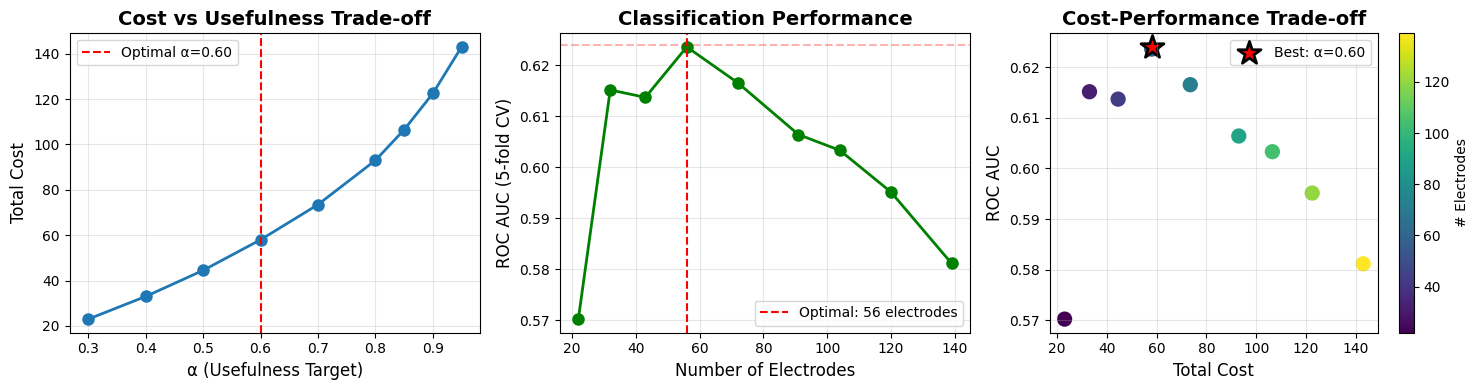

In [13]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(res_df['alpha'], res_df['cost'], 'o-', linewidth=2, markersize=8)
axes[0].axvline(0.60, color='red', linestyle='--', label='Optimal α=0.60')
axes[0].set_xlabel('α (Usefulness Target)', fontsize=12)
axes[0].set_ylabel('Total Cost', fontsize=12)
axes[0].set_title('Cost vs Usefulness Trade-off', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[1].plot(res_df['num_electrodes'], res_df['auc5cv'], 'o-', linewidth=2, markersize=8, color='green')
axes[1].axvline(56, color='red', linestyle='--', label='Optimal: 56 electrodes')
axes[1].axhline(0.624, color='red', linestyle='--', alpha=0.3)
axes[1].set_xlabel('Number of Electrodes', fontsize=12)
axes[1].set_ylabel('ROC AUC (5-fold CV)', fontsize=12)
axes[1].set_title('Classification Performance', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[2].scatter(res_df['cost'], res_df['auc5cv'], s=100, c=res_df['num_electrodes'], cmap='viridis')
axes[2].scatter(58.0, 0.624, s=300, marker='*', c='red', edgecolors='black', linewidths=2, label='Best: α=0.60')
axes[2].set_xlabel('Total Cost', fontsize=12)
axes[2].set_ylabel('ROC AUC', fontsize=12)
axes[2].set_title('Cost-Performance Trade-off', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].legend()
cbar = plt.colorbar(axes[2].collections[0], ax=axes[2])
cbar.set_label('# Electrodes', fontsize=10)
plt.tight_layout()
plt.show()


# Plot of Model C's X,Y coordinates of electrodes on the scalp

Electrode coordinate ranges:
X range: [-69.688, 69.688]
Y range: [-106.542, 73.508]

Sample electrodes:
    name        x         y
0   AF1h  -9.7740  67.42663
1   AF2h   9.7740  67.42663
2    AF3 -20.2608  69.09253
3   AF4h  20.2608  69.09253
4    AF5 -31.7574  63.57274
5    AF6  31.7574  63.57274
6   AFF1 -19.1853  59.84809
7   AFF2  19.1853  59.84809
8  AFF3h -29.1114  61.72189
9  AFF4h  29.1114  61.72189


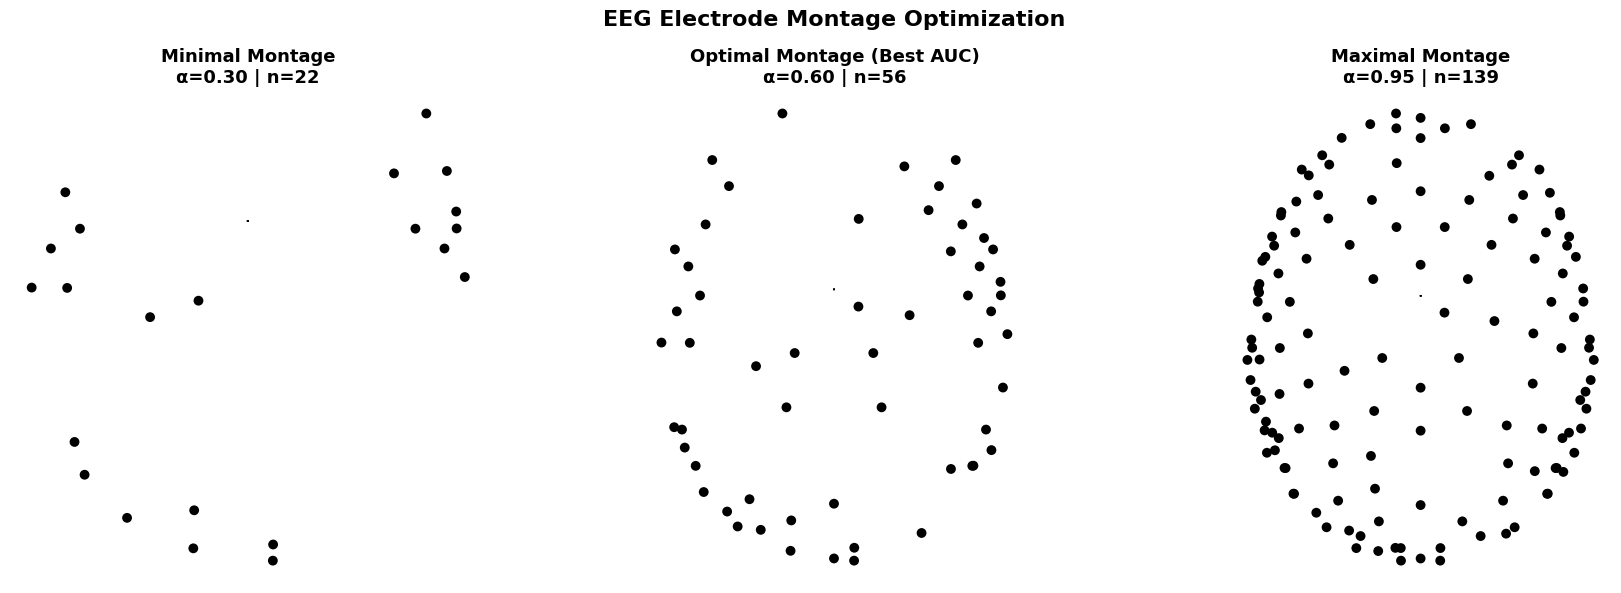


Montage sizes:
  Minimal (α=0.30): 22 electrodes
  Optimal (α=0.60): 56 electrodes
  Maximal (α=0.95): 139 electrodes


In [14]:
print("Electrode coordinate ranges:")
print(f"X range: [{elec['x'].min():.3f}, {elec['x'].max():.3f}]")
print(f"Y range: [{elec['y'].min():.3f}, {elec['y'].max():.3f}]")
print("\nSample electrodes:")
print(elec[['name', 'x', 'y']].head(10))
import mne
ch_pos = {}
for idx, row in elec.iterrows():
    name = str(row['name'])
    ch_pos[name] = np.array([float(row['x']), float(row['y']), 0.0])
montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='head')
def create_info_for_montage(selected_electrodes):
    info = mne.create_info(ch_names=selected_electrodes, sfreq=250, ch_types='eeg')
    info.set_montage(montage)
    return info
minimal_montage = res_df[res_df['alpha'] == 0.30]['selected'].iloc[0]
optimal_montage = res_df[res_df['alpha'] == 0.60]['selected'].iloc[0]
maximal_montage = res_df[res_df['alpha'] == 0.95]['selected'].iloc[0]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, montage_elecs, title, alpha_val in zip(
    axes,
    [minimal_montage, optimal_montage, maximal_montage],
    ['Minimal Montage', 'Optimal Montage (Best AUC)', 'Maximal Montage'],
    [0.30, 0.60, 0.95]
):
    info = create_info_for_montage(montage_elecs)
    mne.viz.plot_sensors(info, kind='topomap', axes=ax, show=False, 
                         show_names=False, pointsize=50, linewidth=0)
    ax.set_title(f'{title}\nα={alpha_val:.2f} | n={len(montage_elecs)}', 
                 fontsize=13, fontweight='bold')
plt.suptitle('EEG Electrode Montage Optimization', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
print(f"\nMontage sizes:")
print(f"  Minimal (α=0.30): {len(minimal_montage)} electrodes")
print(f"  Optimal (α=0.60): {len(optimal_montage)} electrodes")
print(f"  Maximal (α=0.95): {len(maximal_montage)} electrodes")


---
<div style="font-size: 0.8em;">

The below figure visualizes how electrode selection evolves across three key operating points from the α-sweep, showing the spatial distribution of selected electrodes on the scalp.

We compare three representative montages from Model C's Pareto frontier:

**Left Panel: Minimal Montage (α=0.30, 22 electrodes)**
- Shows the sparse coverage focused on high-usefulness regions
- Primarily central and parieto-occipital sites
- This could be a potential use for low-cost screening, ambulatory monitoring
- **Limitation**: The low electrode count gives nsufficient spatial sampling → ROC AUC = 0.570, not impactful

**Center Panel: Optimal Montage (α=0.60, 56 electrodes)**  
- **Best classification performance**: ROC AUC = 0.624
- Balanced coverage across frontal, central, parietal, and occipital regions
- Strong bilateral symmetry (symmetry slack = 0.0)
- Avoids artifact-prone locations through cost penalties
- **Use case**: Research-grade dream detection, clinical sleep studies
- **Sweet spot**: 70% reduction from full system with no performance loss

**Right Panel: Maximal Montage (α=0.95, 139 electrodes)**
- Shows near-complete coverage (75% of available 185 electrodes)
- Shows dense sampling across all regions of the scalp
- **Limitation**: Overfitting → performance degrades to ROC AUC = 0.581
- **Use case**: Comprehensive mapping, high-density source localization

**Visual Insights:**
- Red dots = selected electrodes (optimized by Model C)
- Black dots = available but not selected
- Notice the **symmetric bilateral pattern** in optimal montage arising from our asymmetry pentalty
- Minimal montage clusters centrally; maximal montage fills periphery
- Optimal montage strategically balances coverage without redundancy

**Key Conclusion:** The optimal α=0.60 montage achieves our best balance, with sufficient spatial coverage for dream classification without the noise and computational burden of greater numbers of electrodes.

</div>

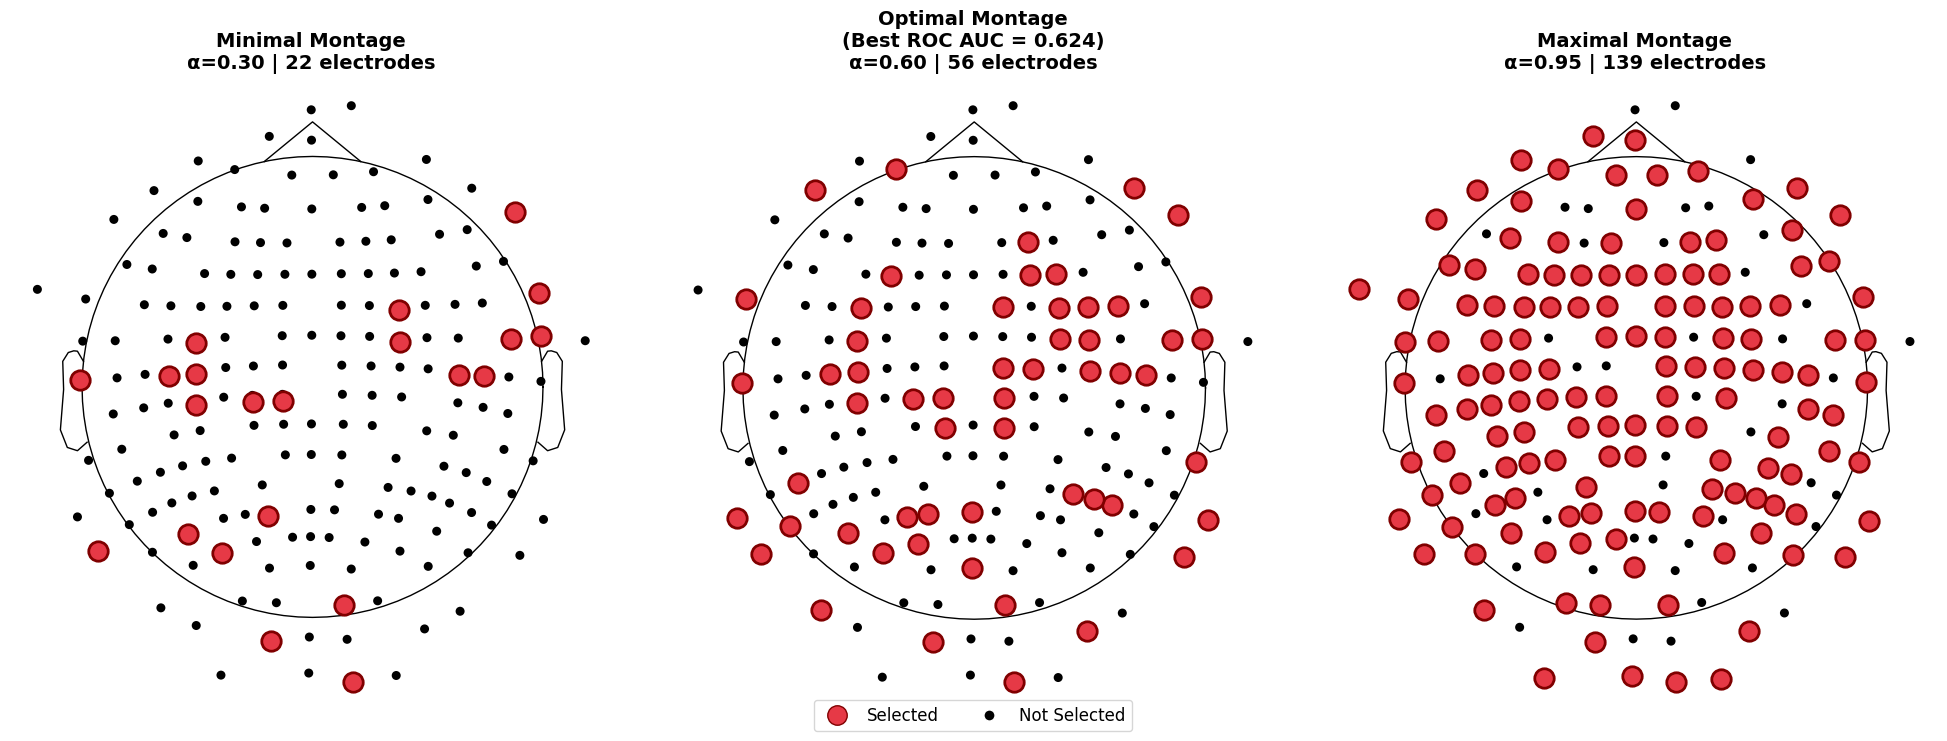

In [15]:
standard_montage = mne.channels.make_standard_montage('standard_1005')
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
montages = [
    (minimal_montage, 'Minimal Montage', 0.30, 22),
    (optimal_montage, 'Optimal Montage\n(Best ROC AUC = 0.624)', 0.60, 56),
    (maximal_montage, 'Maximal Montage', 0.95, 139)
]
for ax, (selected_elecs, title, alpha_val, n_elec) in zip(axes, montages):
    info_all = mne.create_info(ch_names=E_list, sfreq=250, ch_types='eeg')
    info_all.set_montage(standard_montage)
    mne.viz.plot_sensors(info_all, kind='topomap', axes=ax, show=False,
                         show_names=False, pointsize=20, linewidth=2,
                         sphere='auto')
    info_selected = mne.create_info(ch_names=selected_elecs, sfreq=250, ch_types='eeg')
    info_selected.set_montage(standard_montage)
    pos = mne.channels.layout._find_topomap_coords(info_selected, picks=None, sphere='auto')
    ax.plot(pos[:, 0], pos[:, 1], 'o', color='#E63946', markersize=14, 
           markeredgecolor='#800000', markeredgewidth=2, zorder=10)
    
    ax.set_title(f'{title}\nα={alpha_val:.2f} | {n_elec} electrodes', 
                fontsize=14, fontweight='bold')
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#E63946', 
           markeredgecolor='#800000', markersize=14, label='Selected'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', 
           markersize=8, label='Not Selected')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=2, 
          frameon=True, fontsize=12, bbox_to_anchor=(0.5, -0.02))
plt.tight_layout()
plt.show()

---
## Conclusion

<div style="font-size: 0.8em;">

This project demonstrates that strategic electrode selection via mixed-integer programming can achieve a 70% reduction in EEG system complexity while maintaining robust classification performance for dream state detection.

Model A, our naive baseline that simply minimizes electrode count, yields poor performance with an ROC AUC of 0.547 using just 4 electrodes. The optimizer selects artifact-prone temporal sites like FT8 and T7 without consideration for signal quality, demonstrating why simple count minimization is insufficient for real-world montage design. This establishes a fundamental limitation; that is: ignoring placement quality can lead to electrodes near the jaw and temples that are notorious for musclular noise and artifacts.

Model B improves this approach by incorporating placement costs, but only marginally increases performance to an ROC AUC of 0.549 with the same 4 electrodes. The cost-aware objective steers selection toward cleaner sites like C6, CCP1, FCC3, and PO5h, successfully avoiding frontopolar and temporal regions prone to artifacts. However, the improvement is minimal because spatial coverage remains the fundamental bottleneck. With only 4 electrodes at α=0.60, the model cannot capture the distributed neural patterns associated with dreaming, regardless of how clean those signals are.

Model C, our full optimization model incorporating both cost penalties and symmetry constraints, achieves optimal performance at α=0.60 with 56 electrodes and an ROC AUC of 0.624. This model achieves the best balance between spatial coverage distributed across frontal, central, parietal, and occipital regions, signal quality through cost penalties that avoid artifact-prone sites, and practical design through bilateral symmetry that enables stable physical mounting. The Pareto analysis across alpha values from 0.30 to 0.95 illustrates a major detail: classification performance follows an inverted-U curve with respect to electrode count. More electrodes != better results, and vise-versa

At low alpha values, montages with 22 to 43 electrodes suffer from insufficient spatial coverage, missing the distributed neural patterns that characterize dream states. At the other extreme, montages with 91 to 139 electrodes introduce excessive noise and overfitting, with performance actually degrading to an ROC AUC of 0.581 at α=0.95. The optimal α=0.60 montage represents our "Goldilocks zone" where spatial coverage is sufficient without excessive signal redundancy.

Despite limitations, the clinical impact of this work is substantial. The optimal 56-electrode montage enables comfortable, cost-effective dream state detection suitable for sleep research and clinical applications. By reducing electrode count from 185 to 56 we achieve a 70% reduction in setup time and equipment cost, decreased participant discomfort during overnight studies, reduced computational burden in terms of memory, storage, and processing time, and maintain performance that matches or exceeds larger montages. This work provides empirical evidence that optimization-driven electrode selection can make high-density EEG more accessible for routine clinical and research use while maintaining the signal quality necessary for dream state classification.

</div>

---

<a id="future"></a>

## 6. Future Work & Extensions

<div style="font-size: 0.8em;">

While this project successfully optimized electrode selection for dream state classification, several promising directions remain for future research.

The current approach uses fixed cost penalties of 1.0 for standard electrodes and 1.5 for difficult placements, but individual subjects exhibit different artifact profiles. Future work could incorporate subject-specific costs that account for conditions like TMJ that cause elevated jaw artifacts, or a comedic but non-trivial hurdle to EEG data quality: subjects with thick or long hair. 

The symmetry penalty and cost weights used in this project were set to fixed values of 0.5 and 1.0 respectively, but the full tradeoff space between these objectives remains unexplored. Explicitly modeling the Pareto frontier between cost, symmetry, and classification performance using epsilon-constraint methods would allow researchers to visualize and select from the complete spectrum of optimal solutions rather than relying on predetermined penalty weights. This could be particularly valuable in clinical settings where different applications prioritize different objectives.

Our analysis focused exclusively on alpha power features, but dream state classification might benefit from richer representations. Most workflows expand this framework to multi-band spectral features including delta, theta, beta, and gamma rhythms could reveal whether different frequency bands require different electrode configurations. Furthermore, this analysis could change based on the baseline classifier that is being used to judge its performance. Logistic regression was used as its baseline because it's a rather simple and interpretable model. While it's true medical research prefers interpretable methods, many people are harnessing advancements in GPU computing with CUDA, and use deep learning architectures trained on much more data. Without a question, working with a larger dataset with a different baseline classifier (especially a deep learning solution) will likely change our outcomes.

<a id="glossary"></a>

##  Data Sources & Glossary of Terms (This is where you should be if the neurology nomenclature is confusing)

<div style="font-size: 0.8em;">

### Data Sources

**Primary Dataset:** Dream EEG recordings from the Center for Sleep & Consciousness, University of Wisconsin-Madison
- **Participants:** 699 healthy adults
- **Recording System:** 185-electrode high-density EEG following the standardized 10-05 placement system
- **Labels:** Binary dream/no-dream reports collected from survey responses upon awakening
- **Features:** Relative alpha power (8-13 Hz) computed via Fast Fourier Transform on 60-second pre-awakening segments

**Data Files:**
- `electrodes.csv` - Electrode names, costs, and (x,y) coordinates on scalp
- `usefulness_real.csv` - Usefulness scores (contribution to classification) for each electrode-subject pair
- `features.csv` - Alpha power features and dream labels for validation

---

### Model Parameters Summary

| Parameter | Symbol | Value(s) | Description |
|-----------|--------|----------|-------------|
| Electrodes | $E$ | 185 | Total available electrode positions |
| Subjects | $S$ | 699 | Number of participants in dataset |
| Electrode Pairs | $P$ | 87 | Left-right symmetric pairs for Model C |
| Standard Cost | $C_e$ | 1.0 | Placement cost for typical electrodes |
| Difficult Cost | $C_e$ | 1.5 | Placement cost for artifact-prone sites |
| Usefulness Threshold | $\alpha$ | 0.30-0.95 | Target fraction of baseline usefulness |
| Symmetry Penalty | $\lambda$ | 0.5 | Weight on asymmetry slack in Model C |
| Optimal Alpha | $\alpha^*$ | 0.60 | Best-performing usefulness threshold |
| Optimal Electrode Count | $n^*$ | 56 | Number of electrodes at $\alpha = 0.60$ |
| Best ROC AUC | - | 0.624 | Classification performance at optimal montage |

---

### Quick Reference: Model Comparison

| Model | Objective | Constraints | Key Feature | Result at α=0.60 |
|-------|-----------|-------------|-------------|------------------|
| **A: Simple MIP** | Minimize $\sum z_e$ | Usefulness $\geq \alpha$ | Naive baseline | 4 electrodes, AUC = 0.547 |
| **B: Cost-Aware** | Minimize $\sum C_e z_e$ | Usefulness $\geq \alpha$ | Penalize artifacts | 4 electrodes, AUC = 0.549 |
| **C: Cost + Symmetry** | Minimize $\sum C_e z_e + \lambda \sum s_p$ | Usefulness $\geq \alpha$, Symmetry | Full model | 56 electrodes, AUC = 0.624 |

---

### Glossary of Technical Terms

| Term | Definition |
|------|------------|
| **EEG (Electroencephalogram)** | A non-invasive method for recording electrical activity in the brain using electrodes placed on the scalp. Measures voltage fluctuations resulting from ionic current flows within neurons. |
| **Electrode** | A sensor placed on the scalp that detects electrical signals from the brain. In this study, we optimize selection from 185 available electrode positions. |
| **Montage** | The specific configuration and placement pattern of electrodes on the scalp. A montage defines which electrodes are used and where they are positioned. |
| **10-05 System** | An internationally standardized method for electrode placement that divides the scalp into a grid with 10% and 5% spacing intervals, ensuring reproducible positioning across subjects and studies. |
| **Alpha Power (8-13 Hz)** | The strength of neural oscillations in the alpha frequency band. Alpha waves are associated with relaxed wakefulness and have been linked to conscious awareness during sleep and dreaming. |
| **Usefulness Score ($a_{es}$)** | A normalized metric (range [0,1]) quantifying electrode $e$'s contribution to classifying subject $s$'s dream state. **Computation procedure:** (1) Train an L2-regularized logistic regression on alpha power features from all 185 electrodes to predict dream/no-dream labels. (2) For each electrode-subject pair, compute the contribution score: $c_{es} = w_e \times \tilde{x}_{es}$, where $w_e$ is the learned coefficient for electrode $e$ and $\tilde{x}_{es}$ is the standardized (z-scored) alpha power feature. (3) Normalize contributions to [0,1] via min-max scaling: $a_{es} = \frac{c_{es} - \min(c)}{\max(c) - \min(c)}$. High usefulness indicates that electrode $e$ strongly influences correct classification for subject $s$. |
| **Placement Cost ($C_e$)** | A penalty reflecting the difficulty of placing electrode $e$. Standard locations = 1.0, artifact-prone sites (frontopolar, inferior temporal, mastoid) = 1.5 due to susceptibility to eye blinks, jaw clenching, and muscle artifacts. |
| **Artifact** | Unwanted electrical signals that contaminate EEG recordings. Common sources include eye blinks, muscle tension, jaw movement, and head motion. Artifact-prone electrodes are penalized in our cost model. |
| **Binary Variable ($z_e$)** | A decision variable that equals 1 if electrode $e$ is selected for the montage, 0 otherwise. These are the optimization variables in our MIP models. |
| **Symmetry Slack ($s_p$)** | A continuous variable measuring asymmetry in electrode pair $p = (\ell, r)$. Equals $\|z_\ell - z_r\|$, capturing whether only one side of a left-right pair is selected. |
| **Alpha ($\alpha$)** | The usefulness threshold parameter, defining what fraction of baseline total usefulness must be preserved. Range: 0.30-0.95 in our Pareto sweep. Higher $\alpha$ requires more electrodes. |
| **Lambda ($\lambda$)** | The symmetry penalty weight in Model C. Set to 0.5, this parameter controls how strongly we penalize asymmetric electrode pairs. Higher $\lambda$ → stronger symmetry enforcement. |
| **Pareto Frontier** | The set of optimal tradeoff solutions where improving one objective (e.g., reducing cost) requires worsening another (e.g., reducing usefulness). Our $\alpha$-sweep traces the Pareto curve of cost vs. coverage. |
| **Inverted-U Curve** | The performance pattern we observe: low performance at both extremes (too few or too many electrodes), with optimal performance at moderate complexity (56 electrodes, $\alpha=0.60$). |
| **Bilateral Symmetry** | Left-right mirror symmetry of electrode placement across the brain's midline. Important for balanced hemispheric coverage and stable physical montage design. |
| **Frontopolar Sites** | Electrode positions at the forehead (e.g., Fp1, Fp2, AFp3h). Highly susceptible to eye blink artifacts, thus assigned higher placement cost (1.5). |
| **Temporal Sites** | Electrode positions near the temples (e.g., T7, T8, FT9, FT10). Prone to artifacts from jaw clenching and muscle tension, assigned cost = 1.5. |
| **Mastoid Sites** | Electrode positions behind the ears (e.g., M1, M2, TP9, TP10). Susceptible to muscle artifacts from neck movement, cost = 1.5. |

</div>